# 导入所用的包

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import re
import json
from sklearn.preprocessing import MinMaxScaler


# 读入所用的数据文件

In [19]:
# 文件读入
fileName = '.\\id1.csv'
fileData = []
fileData = pd.read_csv(fileName)


# 实验用参数

In [20]:
start_time="2018/11/17 0:0:0"
end_time="2019/1/18 0:0:0"

mask_train="2019-01-08"
mask_test="2019-01-19"
epochs=600
batch_size=1000
learning_rate=0.125

useRegularizer=True   #是否使用正则化项
l2_regularizer=0.01
op="sgd"
structure=[[15,"relu"],[24,"relu"],[40,"relu"],[14,"relu"],[10,"relu"],[8,"relu"],[1,"linear"]]

# 创建目录和excel

In [21]:
import os
now=int(time.time())
filePath=str(now)
fatherPath=os.getcwd()
currentPath=fatherPath+"\\testData\\"+filePath
os.mkdir(currentPath)

# 数据预处理

In [22]:
from preprocess import preprocess
if not os.path.exists("dataSet.npy"):
    preprocess(fileData,start_time,end_time)

# 分割数据集

In [23]:
def seperate(op=1,ratio=0.8,num_train=2000):
    dataFinal = np.load("dataSet.npy").astype(float)
    if op==1:
        np.random.shuffle(dataFinal)# 打乱data的顺序
        # 针对不同模型的数据预处理
        # 归一化
        BPNNscaler = MinMaxScaler().fit(dataFinal)
        yScaler = MinMaxScaler().fit(dataFinal[:,0].reshape(-1, 1))
        data = BPNNscaler.transform(dataFinal)
        # 划分训练集和数据集
        maskTrain = np.array(dataFinal[:,1] <= time.mktime(time.strptime(mask_train, "%Y-%m-%d")), dtype='bool')
        X_train = data[maskTrain, 1:]
        Y_train = data[maskTrain, 0]
        maskTest = np.array(dataFinal[:,1] <= time.mktime(time.strptime(mask_test, "%Y-%m-%d")), dtype='bool')
        X_test = data[maskTest & ~maskTrain, 1:]
        Y_test = data[maskTest & ~maskTrain, 0]
    elif op==2:
        #按比例划分数据集
        np.random.shuffle(dataFinal)# 打乱data的顺序
        # 针对不同模型的数据预处理
        # 归一化
        BPNNscaler = MinMaxScaler().fit(dataFinal)
        yScaler = MinMaxScaler().fit(dataFinal[:,0].reshape(-1, 1))
        data = BPNNscaler.transform(dataFinal)
        length=int(ratio*len(data))
        X_train = data[:length, 1:]
        Y_train = data[:length, 0]
        X_test = data[length, 1:]
        Y_test = data[length, 0]
    else:
        #近似于分割出一个月的前几天，后几天作为测试集
        # 归一化
        BPNNscaler = MinMaxScaler().fit(dataFinal)
        yScaler = MinMaxScaler().fit(dataFinal[:,0].reshape(-1, 1))
        data = BPNNscaler.transform(dataFinal)
        num_test=int(num_train*(1-ratio))
        num_total=num_train+num_test
        mask=[]
        for i in range(len(data)):
            if(i%num_total<num_train):
                mask.append(True)
            else:
                mask.append(False)
        mask=np.array(mask)
        X_train = data[mask, 1:]
        Y_train = data[mask, 0]
        X_test = data[~mask, 1:]
        Y_test = data[~mask, 0]
    return X_train,Y_train,X_test,Y_test,yScaler

In [24]:
X_train,Y_train,X_test,Y_test,yScaler=seperate(op=1)

In [25]:
len(Y_train)

65020

In [26]:
Y_train

array([0.22981366, 0.62732919, 0.46583851, ..., 0.56521739, 0.17391304,
       0.41614907])

In [27]:
Y_true = yScaler.inverse_transform(Y_test.reshape(-1, 1))

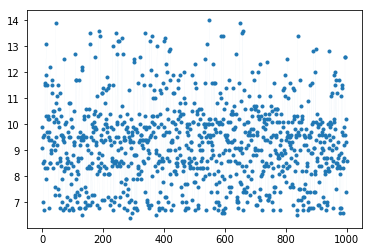

In [28]:
plt.plot(Y_true[:1000],linewidth=0.01,marker=".")

# 建立模型

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import regularizers
from keras.models import load_model

def create_model(structure=structure,learning_rate=learning_rate):
    model = Sequential()
    model.add(Dense(structure[0][0], input_dim=len(X_train[0]), activation=structure[0][1]))#,W_constraint=maxnorm(weight_constraint)
    for i in range(len(structure)):
        if i is 0:
            continue
        if useRegularizer:
            model.add(Dense(structure[i][0],kernel_regularizer=regularizers.l2(l2_regularizer),activation=structure[i][1]))
            #model.add(Dropout(dropout_rate))
        else:
            model.add(Dense(structure[i][0],activation=structure[i][1]))
            #model.add(Dropout(dropout_rate))
    sgd = optimizers.SGD(lr=learning_rate,decay=1e-6,momentum=0.95)
    model.compile(loss="mean_squared_error", optimizer=sgd,metrics=["accuracy"])
    return model

# 网格搜索+训练

In [30]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
model = KerasClassifier(build_fn=create_model,epochs=500,verbose=1)
batch_size = [1000]
learning_rate = [0.01]
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(batch_size=batch_size,learning_rate=learning_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, Y_train)

Epoch 1/500
43346/43346 [==============================] - 2s 41us/step - loss: 2207.1652 - acc: 0.0093
Epoch 2/500
43346/43346 [==============================] - 1s 12us/step - loss: 1691.2707 - acc: 0.0126
Epoch 3/500
43346/43346 [==============================] - 0s 11us/step - loss: 1438.1970 - acc: 0.0143
Epoch 4/500
43346/43346 [==============================] - 1s 12us/step - loss: 1253.8655 - acc: 0.0175
Epoch 5/500
43346/43346 [==============================] - 1s 12us/step - loss: 1130.5571 - acc: 0.0178
Epoch 6/500
43346/43346 [==============================] - 1s 12us/step - loss: 1046.0859 - acc: 0.0179
Epoch 7/500
43346/43346 [==============================] - 1s 15us/step - loss: 988.7847 - acc: 0.0177
Epoch 8/500
43346/43346 [==============================] - 1s 14us/step - loss: 949.7432 - acc: 0.0174
Epoch 9/500
43346/43346 [==============================] - 1s 18us/step - loss: 922.7397 - acc: 0.0179
Epoch 10/500
43346/43346 [==============================] - 1s 12us

43346/43346 [==============================] - 0s 10us/step - loss: 865.9046 - acc: 0.0183
Epoch 79/500
43346/43346 [==============================] - 1s 12us/step - loss: 865.9290 - acc: 0.0179
Epoch 80/500
43346/43346 [==============================] - 0s 9us/step - loss: 865.9731 - acc: 0.0179
Epoch 81/500
43346/43346 [==============================] - 0s 9us/step - loss: 866.0252 - acc: 0.0179
Epoch 82/500
43346/43346 [==============================] - 0s 11us/step - loss: 866.1115 - acc: 0.0178
Epoch 83/500
43346/43346 [==============================] - 0s 10us/step - loss: 866.0521 - acc: 0.0179
Epoch 84/500
43346/43346 [==============================] - 0s 9us/step - loss: 866.0353 - acc: 0.0179
Epoch 85/500
43346/43346 [==============================] - 0s 9us/step - loss: 865.9842 - acc: 0.0179
Epoch 86/500
43346/43346 [==============================] - 0s 9us/step - loss: 866.2877 - acc: 0.0185
Epoch 87/500
43346/43346 [==============================] - 0s 9us/step - loss: 86

43346/43346 [==============================] - 0s 10us/step - loss: 866.2934 - acc: 0.0175
Epoch 157/500
43346/43346 [==============================] - 0s 9us/step - loss: 866.1219 - acc: 0.0179
Epoch 158/500
43346/43346 [==============================] - 0s 9us/step - loss: 866.1307 - acc: 0.0179
Epoch 159/500
43346/43346 [==============================] - 1s 16us/step - loss: 866.0605 - acc: 0.0175
Epoch 160/500
43346/43346 [==============================] - 1s 14us/step - loss: 865.8894 - acc: 0.0179
Epoch 161/500
43346/43346 [==============================] - 1s 13us/step - loss: 866.3545 - acc: 0.0172
Epoch 162/500
43346/43346 [==============================] - 1s 13us/step - loss: 866.1636 - acc: 0.0167: 0s - loss: 877.2871 - acc: 0
Epoch 163/500
43346/43346 [==============================] - 0s 9us/step - loss: 866.2083 - acc: 0.0173
Epoch 164/500
43346/43346 [==============================] - 0s 11us/step - loss: 866.3033 - acc: 0.0174
Epoch 165/500
43346/43346 [===============

43346/43346 [==============================] - 0s 10us/step - loss: 866.3654 - acc: 0.0175
Epoch 234/500
43346/43346 [==============================] - 0s 10us/step - loss: 866.0421 - acc: 0.0179
Epoch 235/500
43346/43346 [==============================] - 0s 11us/step - loss: 866.0721 - acc: 0.0173
Epoch 236/500
43346/43346 [==============================] - 0s 10us/step - loss: 866.0875 - acc: 0.0185
Epoch 237/500
43346/43346 [==============================] - 0s 9us/step - loss: 865.9195 - acc: 0.0179
Epoch 238/500
43346/43346 [==============================] - 0s 10us/step - loss: 866.0129 - acc: 0.0179
Epoch 239/500
43346/43346 [==============================] - 0s 10us/step - loss: 866.3306 - acc: 0.0180
Epoch 240/500
43346/43346 [==============================] - 0s 10us/step - loss: 867.0715 - acc: 0.0175
Epoch 241/500
43346/43346 [==============================] - 0s 11us/step - loss: 866.6295 - acc: 0.0171
Epoch 242/500
43346/43346 [==============================] - 0s 11us/s

43346/43346 [==============================] - 0s 7us/step - loss: 866.1261 - acc: 0.0172
Epoch 312/500
43346/43346 [==============================] - 0s 10us/step - loss: 865.8864 - acc: 0.0179
Epoch 313/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.0021 - acc: 0.0176
Epoch 314/500
43346/43346 [==============================] - 0s 8us/step - loss: 866.1543 - acc: 0.0173
Epoch 315/500
43346/43346 [==============================] - 0s 8us/step - loss: 865.8725 - acc: 0.0179
Epoch 316/500
43346/43346 [==============================] - 0s 6us/step - loss: 865.9808 - acc: 0.0172
Epoch 317/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.2566 - acc: 0.0180
Epoch 318/500
43346/43346 [==============================] - 0s 6us/step - loss: 865.9579 - acc: 0.0179
Epoch 319/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.1644 - acc: 0.0183
Epoch 320/500
43346/43346 [==============================] - 0s 6us/step - lo

43346/43346 [==============================] - 0s 7us/step - loss: 866.4893 - acc: 0.0178
Epoch 390/500
43346/43346 [==============================] - 0s 8us/step - loss: 866.6360 - acc: 0.0189
Epoch 391/500
43346/43346 [==============================] - 0s 10us/step - loss: 866.2951 - acc: 0.0179
Epoch 392/500
43346/43346 [==============================] - 0s 8us/step - loss: 866.0900 - acc: 0.0179
Epoch 393/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.3990 - acc: 0.0179
Epoch 394/500
43346/43346 [==============================] - 0s 6us/step - loss: 866.0303 - acc: 0.0179
Epoch 395/500
43346/43346 [==============================] - 0s 8us/step - loss: 865.9999 - acc: 0.0179
Epoch 396/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.1226 - acc: 0.0179
Epoch 397/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.0773 - acc: 0.0175
Epoch 398/500
43346/43346 [==============================] - 0s 10us/step - l

43346/43346 [==============================] - 0s 8us/step - loss: 866.2728 - acc: 0.0178
Epoch 467/500
43346/43346 [==============================] - 0s 8us/step - loss: 866.1555 - acc: 0.0167
Epoch 468/500
43346/43346 [==============================] - 0s 9us/step - loss: 865.9787 - acc: 0.0179
Epoch 469/500
43346/43346 [==============================] - 0s 9us/step - loss: 866.0675 - acc: 0.0188
Epoch 470/500
43346/43346 [==============================] - 0s 8us/step - loss: 866.0300 - acc: 0.0179
Epoch 471/500
43346/43346 [==============================] - 0s 9us/step - loss: 865.9923 - acc: 0.0175
Epoch 472/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.4284 - acc: 0.0177
Epoch 473/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.0828 - acc: 0.0180
Epoch 474/500
43346/43346 [==============================] - 0s 7us/step - loss: 866.1020 - acc: 0.0179
Epoch 475/500
43346/43346 [==============================] - 0s 7us/step - los

43347/43347 [==============================] - 0s 5us/step - loss: 980436965592528.3750 - acc: 0.0172
Epoch 38/500
43347/43347 [==============================] - 0s 5us/step - loss: 667717487428040.6250 - acc: 0.0182
Epoch 39/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0028     
Epoch 40/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 41/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 42/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 43/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00: 0s - loss: nan - acc: 0.0000
Epoch 44/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 45/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 46/500
43347/43347 [============

43347/43347 [==============================] - 1s 13us/step - loss: nan - acc: 0.0000e+00 0s - loss: nan - acc: 0.0000
Epoch 117/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 118/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 119/500
43347/43347 [==============================] - 1s 12us/step - loss: nan - acc: 0.0000e+00
Epoch 120/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00 0s - loss: nan - acc: 0.0000
Epoch 121/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 122/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 123/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 124/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 125/500
43347/

Epoch 194/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 195/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 196/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 197/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 198/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 199/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 200/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 201/500
43347/43347 [==============================] - 1s 14us/step - loss: nan - acc: 0.0000e+00 0s - loss: nan - acc: 0.00
Epoch 202/500
43347/43347 [==============================] - 1s 15us/step - loss: nan - acc: 0.0000e+00
Epoch 203/500
43347/43347 [===========

43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 272/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 273/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 274/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 275/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 276/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 277/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 278/500
43347/43347 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 279/500
43347/43347 [==============================] - 0s 5us/step - loss: nan - acc: 0.0000e+00
Epoch 280/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - 

Epoch 350/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 351/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 352/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 353/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 354/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 355/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 356/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 357/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 358/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 359/500
43347/43347 [==============================] - 0s 11us/s

43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 429/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 430/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 431/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 432/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 433/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 434/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 435/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00: 0s - loss: nan - acc: 0.0000e+
Epoch 436/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 437/500
43347/43347 [============================

43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 6/500
43347/43347 [==============================] - 1s 15us/step - loss: nan - acc: 0.0000e+00
Epoch 7/500
43347/43347 [==============================] - 1s 17us/step - loss: nan - acc: 0.0000e+00 0s - loss: nan -
Epoch 8/500
43347/43347 [==============================] - 1s 18us/step - loss: nan - acc: 0.0000e+00
Epoch 9/500
43347/43347 [==============================] - 1s 15us/step - loss: nan - acc: 0.0000e+00 0s - loss: nan - acc
Epoch 10/500
43347/43347 [==============================] - 1s 17us/step - loss: nan - acc: 0.0000e+00 0s - loss: nan
Epoch 11/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 12/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 13/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 14/500
43347/43347 [============

43347/43347 [==============================] - 1s 14us/step - loss: nan - acc: 0.0000e+00
Epoch 84/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 85/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 86/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 87/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 88/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 89/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 90/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 91/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 92/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.

43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 163/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 164/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 165/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 166/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 167/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 168/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 169/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 170/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 171/500
43347/43347 [==============================] - 0s 8us/step - loss: nan 

43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 242/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 243/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 244/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 245/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 246/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 247/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 248/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 249/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 250/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - 

43347/43347 [==============================] - 1s 15us/step - loss: nan - acc: 0.0000e+00
Epoch 320/500
43347/43347 [==============================] - 1s 14us/step - loss: nan - acc: 0.0000e+00
Epoch 321/500
43347/43347 [==============================] - 1s 13us/step - loss: nan - acc: 0.0000e+00
Epoch 322/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 323/500
43347/43347 [==============================] - 0s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 324/500
43347/43347 [==============================] - 1s 12us/step - loss: nan - acc: 0.0000e+00
Epoch 325/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 326/500
43347/43347 [==============================] - ETA: 0s - loss: nan - acc: 0.0000e+ - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 327/500
43347/43347 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 328/500
43347/43347 [===============

43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 398/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 399/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 400/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 401/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 402/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 403/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 404/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 405/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 406/500
43347/43347 [==============================] - 0s 8us/step - loss: nan

43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 477/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 478/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 479/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 480/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 481/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 482/500
43347/43347 [==============================] - 0s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 483/500
43347/43347 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 484/500
43347/43347 [==============================] - 0s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 485/500
43347/43347 [==============================] - 0s 10us/step - loss: na

65020/65020 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 55/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 56/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 57/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 58/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 59/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 60/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 61/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 62/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 63/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0

65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 134/500
65020/65020 [==============================] - 1s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 135/500
65020/65020 [==============================] - 1s 17us/step - loss: nan - acc: 0.0000e+00
Epoch 136/500
65020/65020 [==============================] - 1s 15us/step - loss: nan - acc: 0.0000e+00
Epoch 137/500
65020/65020 [==============================] - 1s 13us/step - loss: nan - acc: 0.0000e+00
Epoch 138/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 139/500
65020/65020 [==============================] - 1s 11us/step - loss: nan - acc: 0.0000e+00
Epoch 140/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 141/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 142/500
65020/65020 [==============================] - 1s 10us/step - lo

65020/65020 [==============================] - ETA: 0s - loss: nan - acc: 0.0000e+ - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 212/500
65020/65020 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 213/500
65020/65020 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 214/500
65020/65020 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 215/500
65020/65020 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 216/500
65020/65020 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 217/500
65020/65020 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 218/500
65020/65020 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 219/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 220/500
65020/65020 [=====================

65020/65020 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 288/500
65020/65020 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 289/500
65020/65020 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 290/500
65020/65020 [==============================] - 1s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 291/500
65020/65020 [==============================] - 1s 12us/step - loss: nan - acc: 0.0000e+00
Epoch 292/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 293/500
65020/65020 [==============================] - 1s 12us/step - loss: nan - acc: 0.0000e+00
Epoch 294/500
65020/65020 [==============================] - 1s 11us/step - loss: nan - acc: 0.0000e+00 0s - loss: nan - acc
Epoch 295/500
65020/65020 [==============================] - 1s 12us/step - loss: nan - acc: 0.0000e+00
Epoch 296/500
65020/65020 [==============================] - 1

65020/65020 [==============================] - 1s 15us/step - loss: nan - acc: 0.0000e+00
Epoch 365/500
65020/65020 [==============================] - 1s 12us/step - loss: nan - acc: 0.0000e+00
Epoch 366/500
65020/65020 [==============================] - 1s 16us/step - loss: nan - acc: 0.0000e+00
Epoch 367/500
65020/65020 [==============================] - 1s 13us/step - loss: nan - acc: 0.0000e+00
Epoch 368/500
65020/65020 [==============================] - 1s 12us/step - loss: nan - acc: 0.0000e+00
Epoch 369/500
65020/65020 [==============================] - 1s 15us/step - loss: nan - acc: 0.0000e+00
Epoch 370/500
65020/65020 [==============================] - 1s 14us/step - loss: nan - acc: 0.0000e+00
Epoch 371/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 372/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 373/500
65020/65020 [==============================] - 1s 8us/step - loss

65020/65020 [==============================] - 0s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 441/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 442/500
65020/65020 [==============================] - 1s 8us/step - loss: nan - acc: 0.0000e+00
Epoch 443/500
65020/65020 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 444/500
65020/65020 [==============================] - 0s 6us/step - loss: nan - acc: 0.0000e+00
Epoch 445/500
65020/65020 [==============================] - 1s 9us/step - loss: nan - acc: 0.0000e+00
Epoch 446/500
65020/65020 [==============================] - 1s 10us/step - loss: nan - acc: 0.0000e+00
Epoch 447/500
65020/65020 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 448/500
65020/65020 [==============================] - 0s 7us/step - loss: nan - acc: 0.0000e+00
Epoch 449/500
65020/65020 [==============================] - 0s 7us/step - loss: nan -

In [31]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.006337 using {'batch_size': 1000, 'learning_rate': 0.01}
0.006336 (0.008961) with: {'batch_size': 1000, 'learning_rate': 0.01}


D:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


# 储存训练结果

In [13]:
cv_result = pd.DataFrame.from_dict(grid.cv_results_)
cv_result.to_csv(currentPath+'\\train models.csv',index=False,header=True)

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessi

In [14]:
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,217.968948,3.980923,0.307173,0.030370,1000,0.1,"{'batch_size': 1000, 'learning_rate': 0.1}",0.054535,0.084806,0.121857,0.087066,0.027530,1,0.053984,0.086327,0.122546,0.087619,0.028005
1,214.050793,4.421778,0.419506,0.038954,1000,0.15,"{'batch_size': 1000, 'learning_rate': 0.15}",0.017486,0.016934,0.018364,0.017595,0.000589,3,0.018225,0.018940,0.018225,0.018464,0.000337
2,221.497752,3.804538,0.592549,0.073422,1000,0.2,"{'batch_size': 1000, 'learning_rate': 0.2}",0.017486,0.016564,0.018364,0.017472,0.000735,4,0.018225,0.017233,0.018225,0.017894,0.000468
3,228.801400,1.682067,0.680969,0.032645,1000,0.25,"{'batch_size': 1000, 'learning_rate': 0.25}",0.013149,0.016934,0.017533,0.015872,0.001941,5,0.012550,0.018940,0.018202,0.016564,0.002854
4,239.576393,2.005181,1.037592,0.233387,1000,0.3,"{'batch_size': 1000, 'learning_rate': 0.3}",0.019516,0.018918,0.018364,0.018933,0.000471,2,0.017649,0.017510,0.018225,0.017795,0.000310


In [15]:
best_model=grid.best_estimator_

In [16]:
X_train

array([[7.60607710e-01, 0.00000000e+00, 6.66666667e-02, ...,
        2.17391304e-01, 8.73879989e-01, 5.09803922e-01],
       [2.10441296e-01, 9.09090909e-01, 9.66666667e-01, ...,
        5.96273292e-01, 8.62476242e-01, 9.01960784e-01],
       [6.96151140e-04, 9.09090909e-01, 5.33333333e-01, ...,
        5.83850932e-01, 8.61390171e-01, 8.82352941e-01],
       ...,
       [8.21332604e-01, 0.00000000e+00, 1.66666667e-01, ...,
        3.78881988e-01, 8.66413250e-01, 5.49019608e-01],
       [3.15986478e-02, 9.09090909e-01, 5.66666667e-01, ...,
        4.28571429e-01, 8.69128428e-01, 7.05882353e-01],
       [1.44827649e-01, 9.09090909e-01, 8.00000000e-01, ...,
        5.52795031e-01, 8.64648384e-01, 6.66666667e-01]])

In [17]:
best_model.predict(X_test)

13289/13289 [==============================] - 1s 77us/step


array([[0.00621118],
       [0.00621118],
       [0.00621118],
       ...,
       [0.00621118],
       [0.00621118],
       [0.00621118]])

13289/13289 [==============================] - 0s 6us/step
R^2:-10.882323873966879
Mean:5.333599217397848
Test loss:31.061362028745574


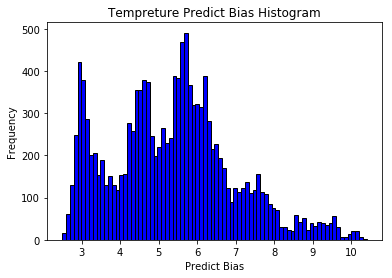

In [18]:
Y_predict  = yScaler.inverse_transform(best_model.predict(X_test).reshape(-1, 1))
Y_true = yScaler.inverse_transform(Y_test.reshape(-1, 1))
test_loss=np.sum(np.square(Y_predict - Y_true))/len(Y_true)
SStot = np.sum((Y_true-np.mean(Y_true))**2)
SSres = np.sum((Y_true-Y_predict)**2)
R2 = 1-SSres/SStot
print("R^2:" + str(R2))
print("Mean:" + str(np.mean(np.abs(Y_predict - Y_true))))
print("Test loss:"+str(test_loss))
plt.xlabel('Predict Bias')
plt.ylabel('Frequency')
plt.title('Tempreture Predict Bias Histogram')
plt.hist(np.abs(Y_predict - Y_true), bins=80, facecolor="blue", edgecolor="black")
plt.savefig(currentPath+"\\Tempreture Predict Bias Histogram by BPNN.png")
plt.show()
plt.close()

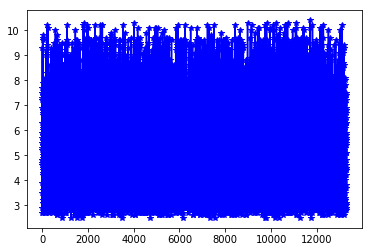

In [19]:
plt.plot(Y_true - Y_predict,marker='*',color='b')
save = pd.DataFrame(Y_true)
save.to_csv(currentPath+'\\Y_true.csv',index=False,header=False)
save = pd.DataFrame(Y_predict)
save.to_csv(currentPath+'\\Y_predict.csv',index=False,header=False)

In [20]:
from functions import create_file
message="R^2 : "+str(R2)+"\n"+"Mean : "+str(np.mean(np.abs(Y_predict - Y_true)))+"\n"+"Test loss:"+str(test_loss)
create_file(currentPath+"\\result.txt",message)